# Tutorial Goal

This tutorial aims to show some example of **trace analysis and visualization**
using a pre-defined set of analysis and plotting functions provided by the
**Filters** and **TraceAnalysis** modules of LISA.

In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')
# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)

In [2]:
# Generate plots inline
%pylab inline

# Python modules required by this notebook
import json
import os

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [3]:
# Let's use an example trace
res_dir = './example_results'
tracefile = os.path.join(res_dir, 'trace.dat')
platformfile = os.path.join(res_dir, 'platform.json')
!tree {res_dir}

./example_results
├── platform.json
├── task_util_chrome.png
├── task_util_keygen.png
├── task_util_lsof.png
├── trace.dat
├── trace.raw.txt
└── trace.txt

0 directories, 7 files


In [4]:
# Trace events of interest
events_to_parse = [
    "sched_switch",
    "sched_wakeup",
    "sched_wakeup_new",
    "sched_contrib_scale_f",
    "sched_load_avg_cpu",
    "sched_load_avg_task",
    "sched_tune_config",
    "sched_tune_tasks_update",
    "sched_tune_boostgroup_update",
    "sched_tune_filter",
    "sched_boost_cpu",
    "sched_boost_task",
    "sched_energy_diff",
    "cpu_frequency",
    "cpu_capacity",
]

# Platform description
with open(platformfile, 'r') as fh:
    platform = json.load(fh)

logging.info("CPUs max capacities:")
logging.info("   big: %5d (cpus: %s)",
             platform['nrg_model']['big']['cpu']['cap_max'],
             platform['clusters']['big'])
logging.info("LITTLE: %5d (cpus: %s)",
             platform['nrg_model']['little']['cpu']['cap_max'],
             platform['clusters']['little'])

# Time range from the analysis
(t_min, t_max) = (0, None)

11:42:19  INFO    : CPUs max capacities:
11:42:19  INFO    :    big:  1024 (cpus: [2, 3])
11:42:19  INFO    : LITTLE:   591 (cpus: [0, 1])


# Trace parsing

In [5]:
# Load the LISA::Trace parsing module
from trace import Trace


# The LISA::Trace module is a wrapper of the TRAPpy FTrace module which
# allows to keep track of platform specific details to support the generation
# of
trace = Trace(platform, res_dir, events_to_parse, window=(t_min,t_max))

11:42:46  INFO    : Collected events spans a 35.314 [s] time interval


Maximum estimated system energy: 3102


Notice how some platform specific data are collected and reported by the
LISA::Trace module

In [6]:
# This is the standard TRAPpy::FTrace object, already configured for the
# analysis related to the events of interest
ftrace = trace.ftrace
logging.info("List of events identified in the trace:")
for event in ftrace.class_definitions.keys():
    logging.info("   %s", event)

11:42:46  INFO    : List of events identified in the trace:
11:42:46  INFO    :    sched_load_avg_task
11:42:46  INFO    :    cpu_frequency
11:42:46  INFO    :    cpu_capacity
11:42:46  INFO    :    sched_tune_boostgroup_update
11:42:46  INFO    :    sched_load_avg_cpu
11:42:46  INFO    :    sched_boost_cpu
11:42:46  INFO    :    sched_wakeup_new
11:42:46  INFO    :    sched_tune_config
11:42:46  INFO    :    sched_boost_task
11:42:46  INFO    :    sched_tune_tasks_update
11:42:46  INFO    :    sched_tune_filter
11:42:46  INFO    :    sched_energy_diff
11:42:46  INFO    :    sched_switch
11:42:46  INFO    :    sched_contrib_scale_f
11:42:46  INFO    :    sched_wakeup


In [7]:
# Original TRAPpy::FTrace DataSet are still accessible by specifying the
# trace event name of interest
trace.df('sched_load_avg_task').head()

,__comm,__cpu,__pid,comm,cpu,load_avg,load_sum,period_contrib,pid,util_avg,util_sum,cluster
Time,,,,,,,,,,,,
0.000014,<...>,1,20278,trace-cmd,1,58,2811439,916,20278,33,1601714,LITTLE
0.000229,<...>,1,20278,trace-cmd,1,59,2820191,111,20278,33,1612418,LITTLE
0.000334,<idle>,0,0,sh,0,0,0,957,20277,0,0,LITTLE
0.000982,sh,0,20277,sh,0,5,285169,710,20277,3,164585,LITTLE
0.001178,sh,0,20277,sh,0,5,355825,903,20277,3,205364,LITTLE


# Predefined LISA Filtering Functions

In [8]:
from filters import Filters

fl = Filters(trace)
fl.setXTimeRange(t_min, t_max)

11:42:47  INFO    : Set plots time range to (0.000000, 35.313536)[s]
11:42:47  INFO    : Set plots time range to (0.000000, 35.313536)[s]


## Top BIG tasks

In [9]:
# Get a list of tasks which are the most big in the trace
top_big_tasks = fl.topBigTasks(
    max_tasks=3,          # Maximum number of tasks to report
    min_utilization=None, # Minimum utilization to be considered "big"
                          # default: LITTLE CPUs max capacity
    min_samples=100,      # Number of samples over the minimum utilization 
)

Total 120 tasks with at least 100 "utilization" samples > 591
Top 3 "big" tasks:
      count unique     top  freq
pid                             
20672  2426      2  keygen  2422
20705  1866      1  chrome  1866
20803   662      2    lsof   653


In [10]:
# The collected information is available for further analysis
top_big_tasks

{'chrome': 20705, 'keygen': 20672, 'lsof': 20803}

Tasks which have been a "utilization" of 591 for at least 100 samples


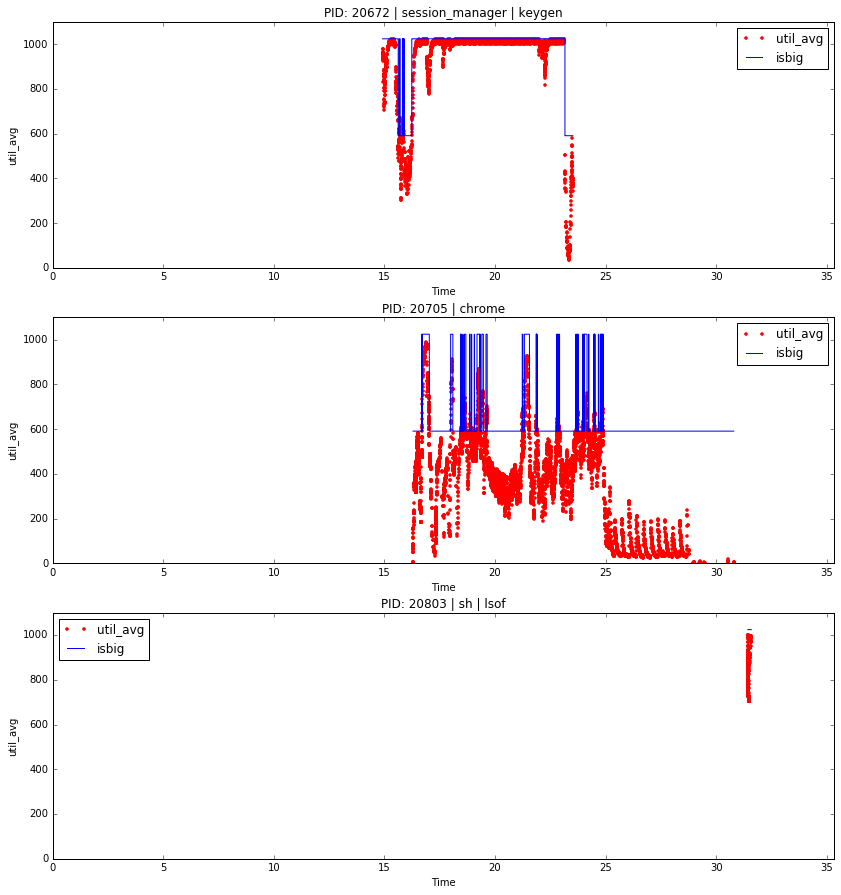

In [22]:
# Plot utilization of "big" tasks decorated with platform specific capacity information
fl.plotBigTasks()

## Top WAKEUP tasks

In [12]:
top_wakeup_tasks = fl.topWakeupTasks(
    max_tasks=5,     # Maximum number of tasks to report
    min_wakeups=100  # Minimum number of wakeup to be reported
)

Top 5 "big" tasks:
      count unique              top  freq
pid                                      
20527  6184      1           chrome  6184
1364   5731      1   ksdioirqd/mmc2  5731
7      5432      1      rcu_preempt  5432
20552  4192      1  Chrome_IOThread  4192
20596  4096      1  Chrome_ChildIOT  4096


### Wakeup vs Forks

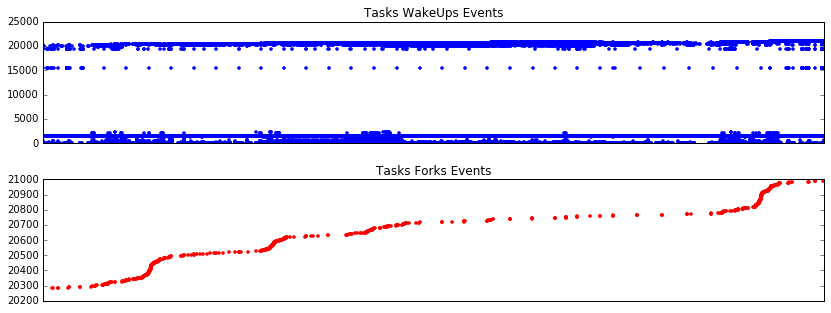

In [13]:
fl.plotWakeupTasks(per_cluster=False)

### Wakeup per cluster

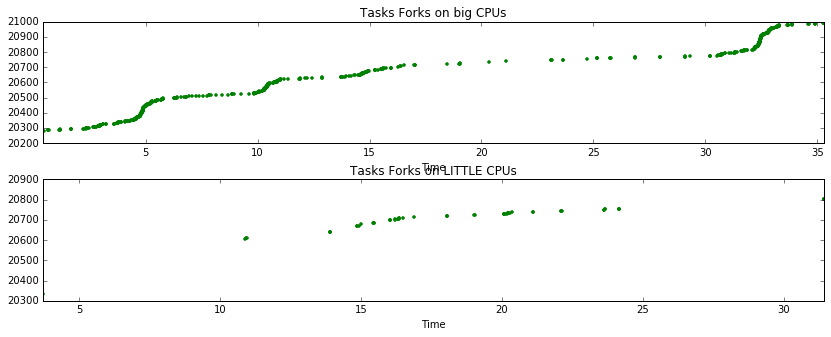

In [14]:
fl.plotWakeupTasks(per_cluster=True)

## RT Tasks

In [15]:
fl.rtTasks(max_prio=100)

{10: 'migration/0',
 11: 'watchdog/0',
 12: 'watchdog/1',
 13: 'migration/1',
 17: 'watchdog/2',
 18: 'migration/2',
 22: 'watchdog/3',
 23: 'migration/3',
 118: 'kschedfreq:0',
 119: 'kschedfreq:2',
 136: 'kworker/0:1H',
 138: 'kworker/1:1H',
 239: 'loop0',
 264: 'kworker/2:1H',
 286: 'kworker/3:1H',
 492: 'daisydog',
 1364: 'ksdioirqd/mmc2',
 2298: 'kworker/u9:4',
 20088: 'kworker/u9:0',
 20693: 'kworker/u9:1'}

# Predefined LISA TraceAnslysis Functions

In [16]:
# Import the LISA::TraceAnalysis module
from trace_analysis import TraceAnalysis

ta = TraceAnalysis(
    trace,               # LISA::Trace object
    tasks=top_big_tasks, # (optional) list of tasks to plot
    plotsdir=res_dir
)

11:44:30  INFO    : Set plots time range to (0.000000, 35.313536)[s]


In [17]:
# Define time ranges for all the time based plots
ta.setXTimeRange(t_min, t_max)

11:44:33  INFO    : Set plots time range to (0.000000, 35.313536)[s]


11:44:44  INFO    :   task           chrome found, pid: [19933, 19990, 20052, 20302, 19949, 20017, 20324, 20019, 20026, 19950, 19938, 20477, 20481, 20482, 20484, 20486, 20488, 20490, 20491, 20492, 20527, 20531, 20532, 20533, 20535, 20537, 20539, 20540, 20541, 20542, 20543, 20544, 20545, 20546, 20547, 20548, 20549, 20550, 20551, 20552, 20553, 20554, 20555, 20558, 20560, 20592, 20593, 20594, 20595, 20596, 20598, 20600, 20602, 20604, 20612, 20613, 20615, 20616, 20617, 20618, 20619, 20620, 20621, 20622, 20623, 20624, 20628, 20629, 20630, 20635, 20638, 20666, 20677, 20679, 20680, 20681, 20682, 20683, 20684, 20685, 20687, 20688, 20689, 20690, 20691, 20692, 20694, 20695, 20699, 20700, 20701, 20702, 20703, 20704, 20705, 20706, 20707, 20708, 20709, 20710, 20711, 20712, 20713, 20714, 20721, 20722, 20723, 20730, 20731, 20732, 20733, 20734, 20735, 20736, 20737, 20738, 20757, 20791, 20792, 20960, 20963, 20964, 20965, 20971, 20973, 20975, 20976, 20977]
11:44:44  INFO    :   task             lsof fou

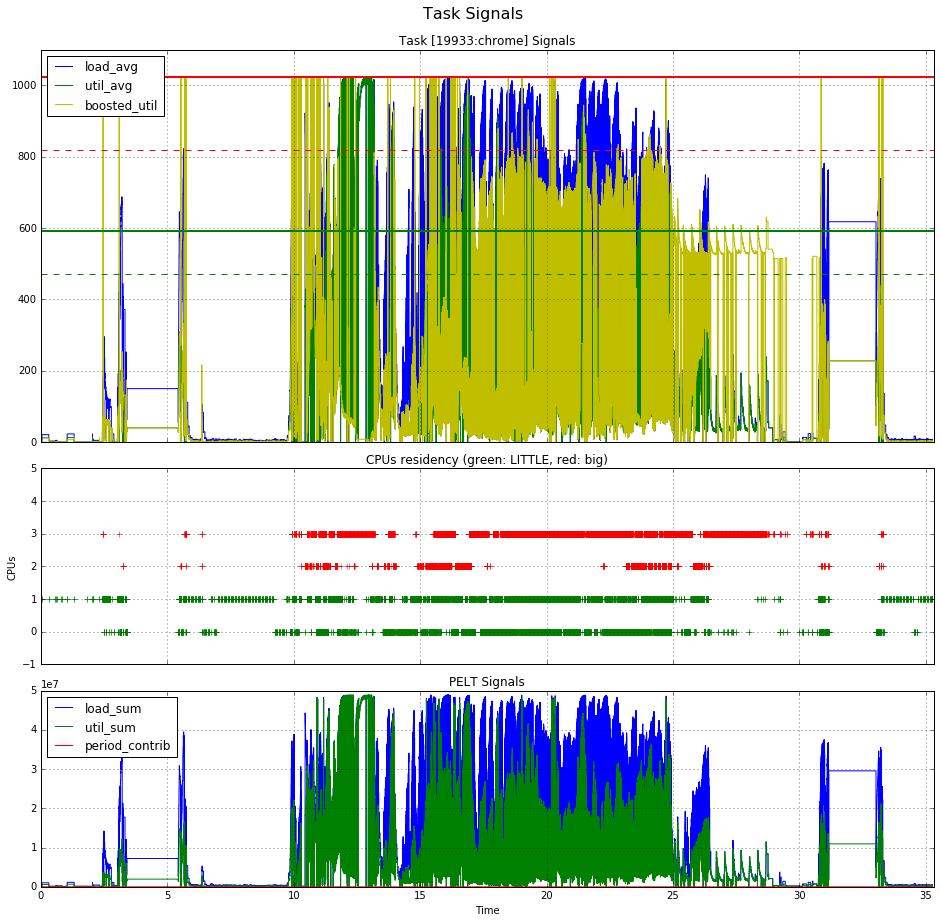

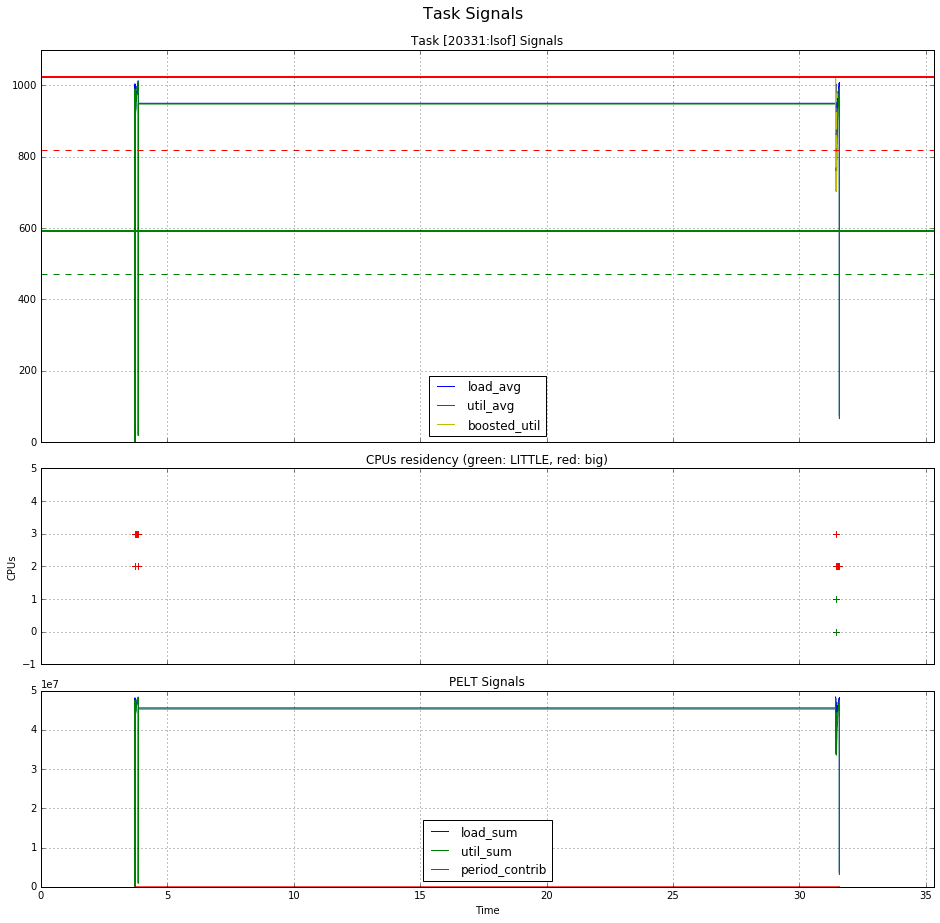

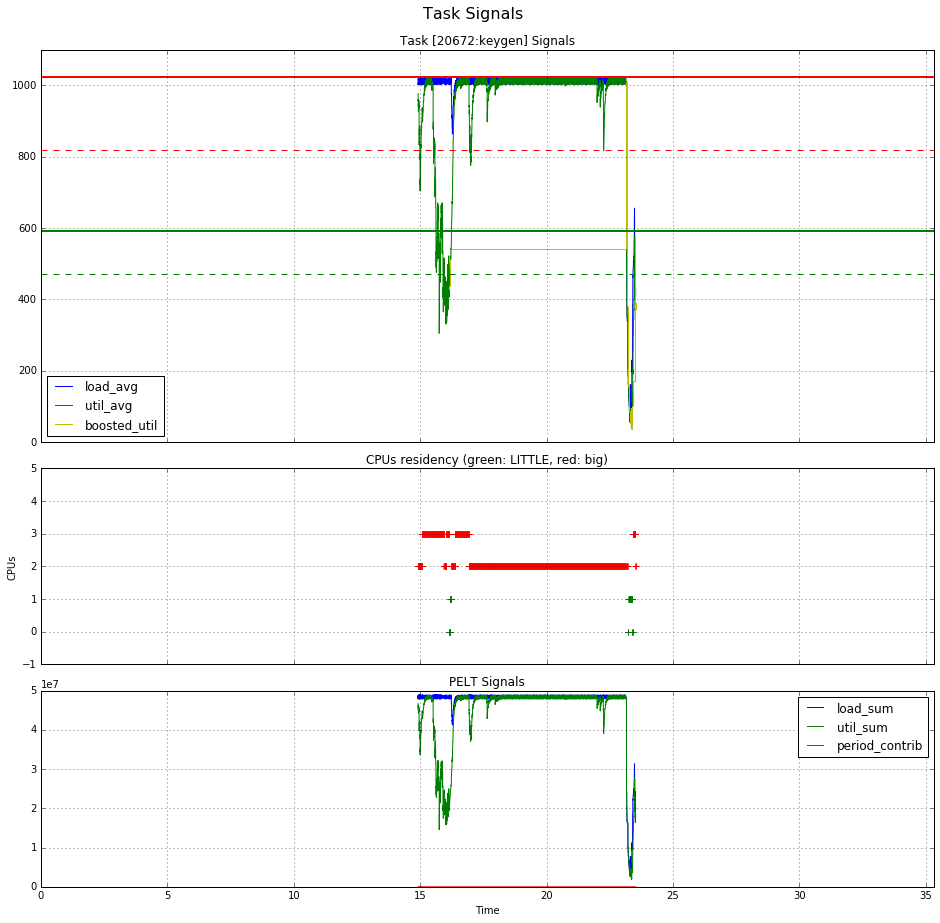

In [18]:
ta.plotTasks(top_big_tasks)

11:45:13  WARNING : Events [sched_overutilized] not found, plot DISABLED!
11:45:13  WARNING : Events [sched_overutilized] not found, plot DISABLED!
11:45:13  INFO    : LITTLE cluster average frequency: 0.918 GHz
11:45:13  INFO    : big    cluster average frequency: 1.169 GHz


(0.91760603617064707, 1.1693335360754311)

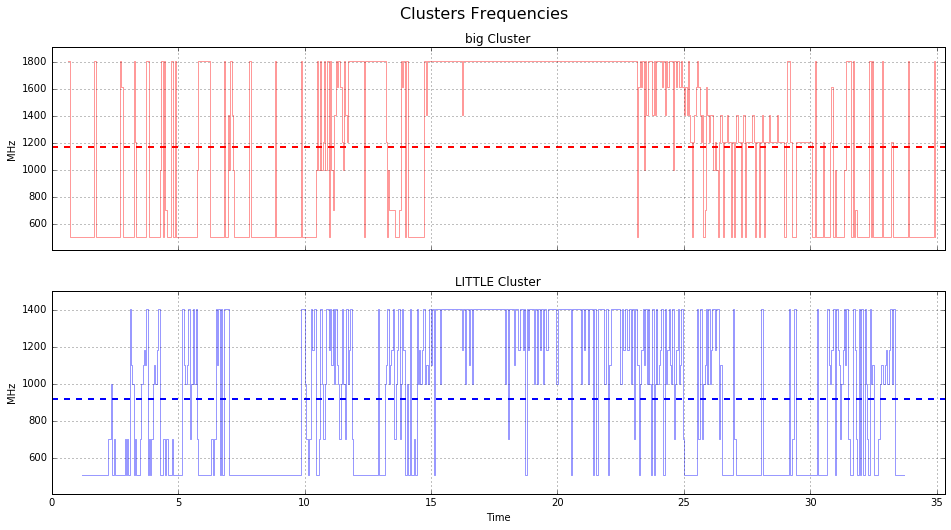

In [19]:
# Cluster frequencies
ta.plotClusterFrequencies()

11:45:58  INFO    : Plotting EDiff data just for task(s) [{'chrome': 20705, 'lsof': 20803, 'keygen': 20672}]
11:45:58  WARNING : Events [sched_overutilized] not found, plot DISABLED!
/home/derkling/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:2767: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=25.777079, right=25.777079
  'left=%s, right=%s') % (left, right))
11:45:58  WARNING : Events [sched_overutilized] not found, plot DISABLED!
11:45:58  WARNING : Events [sched_overutilized] not found, plot DISABLED!
11:45:58  WARNING : Events [sched_overutilized] not found, plot DISABLED!


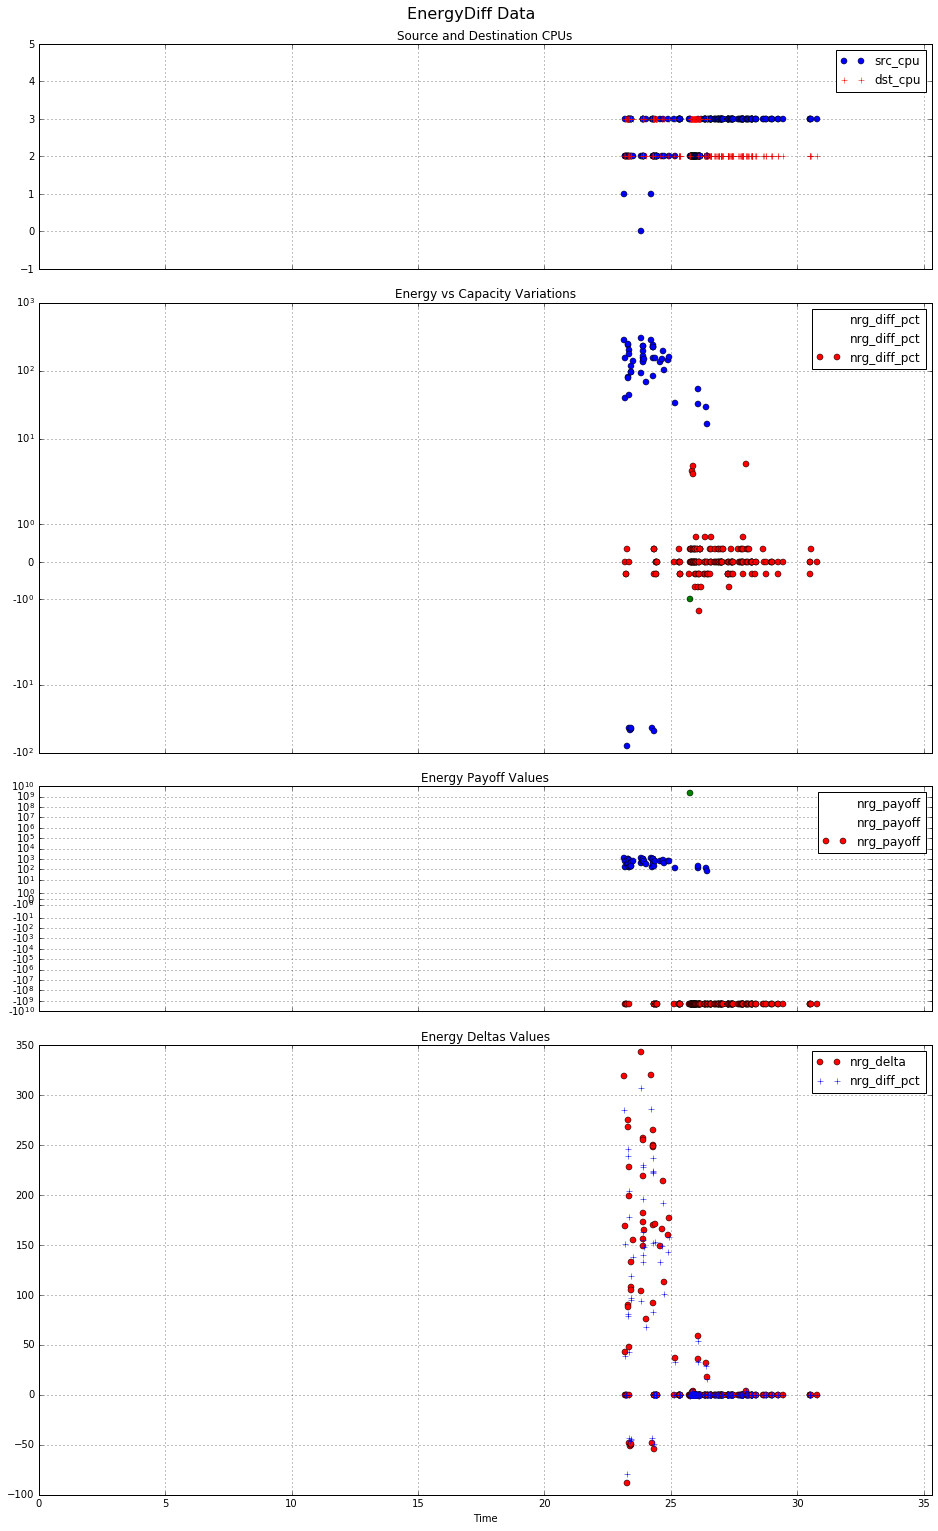

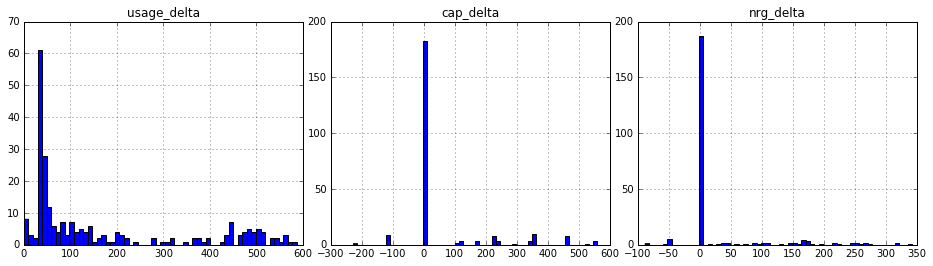

In [21]:
# Plots SchedTune's Energy-Diff Space Filtering
ta.plotEDiffTime(top_big_tasks)